# Upload files in Google Colab
If you are running this Jupyter Notebook on Google Colab, run this cell to upload the data files (train_inputs.csv, train_targets.csv, test_inputs.csv, test_targets.csv) in the colab virtual machine.  You will be prompted to select files that you would like to upload. 

If you are running this Jupyter Notebook on your computer, you do not need to run this cell.

In [ ]:
from google.colab import files
uploaded = files.upload()
%ls

# Import libraries 
Do not use any other Python library.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function: load_logistic_regression_data

This function loads the data for Logistic Regression from a local drive into RAM

Outputs:

*   **train_inputs**: numpy array of N training data points x M features
*   **train_labels**: numpy array of N training labels
*   **test_inputs**: numpy array of N' test data points x M features
*   **test_labels**: numpy array of N' test labels

In [ ]:
def load_logistic_regression_data():
  test_inputs = np.genfromtxt('test_inputs.csv', delimiter=',')
  test_labels = np.genfromtxt('test_labels.csv', delimiter=',')
  train_inputs = np.genfromtxt('train_inputs.csv', delimiter=',')
  train_labels = np.genfromtxt('train_labels.csv', delimiter=',')
  return train_inputs, train_labels, test_inputs, test_labels

# Function: sigmoid

This function implements the logistic sigmoid.

Input:
*   **input**: vector of inputs (numpy array of floats)

Output:
*   **output**: vector of outputs (numpy array of floats)

In [ ]:
def sigmoid(input):
    return 1 / (1 + np.exp(-input))

# Function: predict_logistic_regression

This function uses a vector of weights to make predictions for a set of inputs.  The prediction for each data point is a distribution over the labels.  Assume that there are only two possible labels {0,1}.

Inputs:
*   **inputs**: matrix of input data points for which we want to make a prediction (numpy array of N data points x M+1 features)
*   **weights**: vector of weights (numpy array of M+1 weights)

Output:
*   **predicted_probabilities**: matrix of predicted probabilities (numpy array of N data points x 2 labels)

In [ ]:
def predict_logistic_regression(inputs, weights):
  ones = sigmoid(weights@inputs.T)
  zeros = 1 - ones
  predicted_probabilities = np.array([ones, zeros])
  return predicted_probabilities

# Function eval_logistic_regression

This function evaluates a set of predictions by computing the negative log probabilities of the labels and the accuracy (percentage of correctly predicted labels).  Assume that there are only two possible labels {0,1}.  A data point is correctly labeled when the probability of the target label is >= 0.5.

Inputs:
*   **inputs**: matrix of input data points for which we will evaluate the predictions (numpy array of N data points x M+1 features)
*   **weights**: vector of weights (numpy array of M+1 weights)
*   **labels**: vector of target labels associated with the inputs (numpy array of N labels)

Outputs:
*   **neg_log_prob**: negative log probability of the set of predictions (float)
*   **accuracy**: percentage of correctly labeled data points (float)

In [ ]:
def eval_logistic_regression(inputs, weights, labels):
  predicted = predict_logistic_regression(inputs, weights)
  label = np.array([labels, 1-labels])
  prediction = np.log(predicted)
  sum_1 = np.einsum('ij,ij->ij', label, prediction).sum(axis=0)
  neg_log_prob = - np.sum(sum_1)
  def f(x):
    if x >= 0.5:
      return 1
    else:
      return 0
  predict = np.array(list(map(f, predicted[0,:])))
  accuracy = np.mean( labels == predict)
  return neg_log_prob, accuracy

Function: initialize_weights

This function initializes the weights uniformly at random in the interval [-0.05,0.05]

Input:
*   **n_weights**: # of weights to be initialized (integer)

Output:
*   **random_weights**: vector of weights (numpy array of floats)

In [ ]:
def initialize_weights(n_weights):
  random_weights = np.random.uniform(low=-0.05, high=0.05, size=n_weights)
  return random_weights

# Function train_logistic_regression

This function optimizes a set of weights for logistic regression based on a training set.  Initialize the weights with the function initialize_weights.  Implement Newton's algorithm to optimize the weights.  Stop Newton's algorithm when the maximum change for all weights is less than 0.001 in two consecutive iterations. Assume that there are only two labels {0,1}.

Inputs:
*   **train_inputs**: matrix of input training points (numpy array of N data points x M+1 features)
*   **train_labels**: vector of labels associated with the inputs (numpy array of N labels)
*   **lambda_hyperparam**: lambda hyperparameter used to adjust the importance of the regularizer (scalar)

Output:
*   **weights**: vector of weights that have been optimized (numpy array of M+1 weights)



In [ ]:
def train_logistic_regression(train_inputs, train_labels, lambda_hyperparam):
  weights = initialize_weights(len(train_inputs[0]))
  newWeight = weights
  while True:
    weights = newWeight
    prediction = predict_logistic_regression(train_inputs, weights)
    diff = prediction[0] - train_labels
    # Define gradient
    gradient = np.dot(train_inputs.T, diff) + lambda_hyperparam*weights
    # Define R matrix
    R = prediction[0]*prediction[1]
    R = np.diag(R)
    # Fill in hyper param
    hyperParam = np.empty(len(train_inputs[0]))
    hyperParam.fill(lambda_hyperparam)
    hyperParamMatrix = np.diag(hyperParam)
    #Create Hessian Matrix
    Hessian = np.matmul(np.matmul(train_inputs.T, R), train_inputs) + hyperParamMatrix
    #change
    change = np.linalg.inv(Hessian)@gradient
    newWeight = weights - change
    change = max(np.abs(change))
    if change <= 0.001:
      weights = newWeight
      prediction = predict_logistic_regression(train_inputs, weights)
      diff = prediction[0] - train_labels
      # Define gradient
      gradient = np.dot(train_inputs.T, diff) + lambda_hyperparam*weights
      # Define R matrirx
      R = prediction[0]*prediction[1]
      R = np.diag(R)
      # Fill in hyper param
      hyperParam = np.empty(len(train_inputs[0]))
      hyperParam.fill(lambda_hyperparam)
      hyperParamMatrix = np.diag(hyperParam)
      #Create Hessian Matrix
      Hessian = np.matmul(np.matmul(train_inputs.T, R), train_inputs) + hyperParamMatrix
      #change
      change = np.linalg.inv(Hessian)@gradient
      newWeight = weights - change
      change = max(np.abs(change))
      if change <= 0.001:
        break
  return newWeight



# Function cross_validation_logistic_regression

This function performs k-fold cross validation to determine the best lambda hyperparameter in logistic regression

Inputs:
*   **k_folds**: # of folds in cross-validation (integer)
*   **hyperparameters**: list of hyperparameters where each hyperparameter is a different lambda value (list of floats)
*   **inputs**: matrix of input points (numpy array of N data points by M+1 features)
*   **labels**: vector of labels associated with the inputs (numpy array of N labels)

Outputs:
*   **best_hyperparam**: best lambda value for logistic regression (float)
*   **best_neg_log_prob**: negative log probabilty achieved with best_hyperparam (float)
*   **neg_log_probabilities**: vector of negative log probabilities for the corresponding hyperparameters (numpy array of floats)



In [ ]:
def cross_validation_logistic_regression(k_folds, hyperparameters, inputs, labels):
  size = len(inputs)//k_folds
  params = {}
  test_start = 0
  test_end = size
  for i in range(k_folds):
    test_set = inputs[test_start:test_end]
    test_labels = labels[test_start:test_end]
    train_set =  np.vstack((inputs[:test_start],inputs[test_end:]))
    train_labels= np.append(labels[:test_start],labels[test_end:])
    for p in hyperparameters:
      weights = train_logistic_regression(train_set, train_labels, p)
      params[p] = params.get(p, 0) + eval_logistic_regression(test_set, weights, test_labels)[0]
    test_start = test_end
    test_end += size
  for i in params:
    params[i] = params[i] / k_folds
  best_hyperparam = min(params, key = params.get)
  best_neg_log_prob = min(params.values())
  neg_log_probabilities = np.zeros(len(hyperparameters))
  for i in range(len(hyperparameters)):
    neg_log_probabilities[i] = params[hyperparameters[i]]
  return best_hyperparam, best_neg_log_prob, neg_log_probabilities

# Function: plot_logistic_regression_neg_log_probabilities

Function that plots the negative log probabilities for different lambda values (hyperparameters) in logistic regression based on cross validation

Inputs:
*   **neg_log_probabilities**: vector of negative log probabilities for the corresponding hyperparameters (numpy array of floats)
*   **hyperparams**: list of hyperparameters where each hyperparameter is a different lambda value (list of floats)

In [ ]:
def plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams):
  plt.plot(hyperparams,neg_log_probabilities)
  plt.ylabel('negative log probability')
  plt.xlabel('lambda')
  plt.show()

# Main Logistic Regression code

Load data (rescale the inputs to be in the [-1,1] range, add 1 at the end of each datapoint and rename the labels 5,6 to 0,1).
Use k-fold cross validation to find the best lambda value for logistic regression.
Plot the negative log probabilities for different lambda values.
Test logistic regression with the best lambda value.

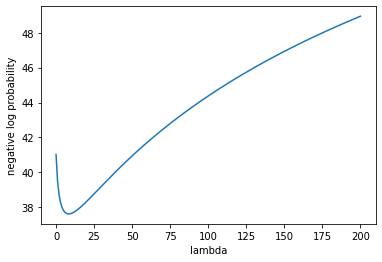

best lambda: 8
best cross validation negative log probability: 37.60806425509706
test accuracy: 0.8727272727272727
test negative log probability: 33.29202902957885


In [ ]:
# load data
train_inputs, train_labels, test_inputs, test_labels = load_logistic_regression_data()

# rescale inputs in the [-1,1] range
train_inputs = (train_inputs - 8)/8
test_inputs = (test_inputs - 8)/8

# add 1 at the end of each data point
train_inputs = np.concatenate((train_inputs,np.ones((train_inputs.shape[0],1))),1)
test_inputs = np.concatenate((test_inputs,np.ones((test_inputs.shape[0],1))),1)

# rename the classes 5,6 to 0,1
train_labels = train_labels.astype(int) - 5
test_labels = test_labels.astype(int) - 5
# lambda values to be evaluated by cross validation
#hyperparams = range(201)
hyperparams = range(201)
k_folds = 10
best_lambda, best_neg_log_prob, neg_log_probabilities = cross_validation_logistic_regression(k_folds,hyperparams,train_inputs,train_labels)

# plot results
plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams)
print('best lambda: ' + str (best_lambda))
print('best cross validation negative log probability: ' + str(best_neg_log_prob))

# train and evaluate with best lambda
weights = train_logistic_regression(train_inputs,train_labels,best_lambda)
neg_log_prob, accuracy = eval_logistic_regression(test_inputs, weights, test_labels)
print('test accuracy: ' + str(accuracy))
print('test negative log probability: ' + str(neg_log_prob))

Q2

Logistic regression works best on classifying data that is linearly separable and when $P(x|c_k)$ are members of the exponential family. Where as KNN works better with data that is non-linearly separable and doesn't require the data noise to follow any distribution. KNN can represent a larger hypothesis space, hence it is more expressive.

The test accuracy for KNN was at around 79%, where as the test accuracy for logistic regression is 87%. Logistic regression model performs better for this set of data. This could mean the data might have a distribution close to an exponential family distribution.  There could also have been a lot of points in different classes that were close to each other but the data could have been linearly separated, which results in KNN being less accurate than Logistic Regression. At the same time, KNN was not weighted, so this could have lead to inaccuracy as well.



In [ ]:
weights = train_logistic_regression(train_inputs, train_labels, 0)
weights

array([ 6.09961925e-02, -3.63528065e-01, -3.06369745e-01, -8.65983938e-02,
       -5.60790631e-01, -1.48669076e+00, -3.71081986e-01, -2.90893461e-01,
       -6.40147888e-01, -9.10784651e-02, -7.84653557e-01,  1.92811474e-02,
       -3.97892869e-01, -1.20117472e+00,  6.08786128e-02,  2.72554618e-01,
       -4.17122298e-01, -4.53364747e-01,  4.59471658e-02,  4.43235776e-01,
       -3.85014146e-01,  6.64372746e-01,  2.52934854e-01, -1.79300694e-01,
       -4.83791753e-01, -1.19516043e-01, -6.24006549e-04, -2.91636756e-01,
       -5.52823900e-01, -1.16920109e-01,  8.01049063e-01, -1.81372209e-01,
       -8.84709546e-01,  1.40229746e-01,  4.52359641e-01,  2.16486269e-01,
        6.89394847e-02,  6.37208770e-01,  3.43708096e-01,  4.08490416e-01,
       -4.01185924e-02, -1.58831916e-01,  1.77788930e+00,  7.28548724e-01,
        7.64249850e-02, -1.62876308e-01, -1.23550640e-01,  3.38562183e-01,
       -2.36560359e-02,  7.13805129e-01,  6.71155857e-01,  5.71865156e-01,
       -5.23004378e-01,  

In [ ]:
print("accuracy:",eval_logistic_regression(test_inputs, weights, test_labels)[1])

accuracy: 0.8636363636363636


The code above looks at the weights on the training set with $\lambda = 0$, so the larger weights are not penalized. If any of the weights have a really large value or a really small value, then this could indicate that the data is very linearly separable. This is because to reach $\sigma(w^Tx)->1$, need $w^Tx -> \infty$ and therefore $||w|| -> \infty$. So if the data is perfectly linearly separable, then weights $-> \pm\infty$. For this dataset, none of the weights are super large or super small, so the data isn't perfectly linearly separable. At the same time, if the data is linearly separable, then the accuracy should be close to 100%. Here, the accuracy is at 86%, not super high.